# Working with clusters

This notebook shows how to work with clusters in CLAP. 
We will use a cluster `npb-cluster` defined in `examples/cli/1. Creating a cluster.ipynb` notebook (pre-requesite). 

This notebook covers:
* How to start and setup a cluster
* How to grow a cluster (adding more nodes to it) and how to shrink it
* How to get cluster nodes

In [1]:
import sys
sys.path.append('../..')

Installing matplotlib package

In [2]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
import yaml
import time
import glob
from dataclasses import asdict
from app.cli.modules.node import get_config_db, get_node_manager
from app.cli.modules.role import get_role_manager
from app.cli.modules.cluster import get_cluster_config_db, get_cluster_manager
from clap.utils import float_time_to_string, path_extend
from clap.executor import SSHCommandExecutor, AnsiblePlaybookExecutor

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
configuration_db = get_config_db()
cluster_config_db = get_cluster_config_db()
node_manager = get_node_manager()
role_manager = get_role_manager()
cluster_manager = get_cluster_manager()
# Private's path (usually ~/.clap/private/) will be used for other methods
private_path = node_manager.private_path

`cluster_config_db` will load all cluster configs at `~/.clap/configs/clusters/` and will store all in the `clusters` member. 
`clusters` is a dictionary, where the keys are the name of cluster configuration the values are dataclasses of type `ClusterConfig`.
- Note: by default, CLAP looks for information at `~/.clap/` directory. However, in case the CLAP_PATH environment variable is defined, CLAP will look for configurations and other information at ${CLAP_PATH}.

Let's list all cluster configurations and get the configuration named `npb-cluster`.

In [5]:
print(list(cluster_config_db.clusters.keys()))

['npb-cluster']


In [6]:
npb_cluster_config = cluster_config_db.clusters['npb-cluster']
print(npb_cluster_config)

ClusterConfig(cluster_config_id='npb-cluster', options=None, before_all=[], before=[], after_all=[SetupConfig(roles=[], actions=[RoleActionType(role='npb', action='run', extra={})])], after=[], nodes={'npb-type-t2.medium': NodeConfig(type='type-t2.medium', count=2, min_count=2, setups=[SetupConfig(roles=[RoleAdd(name='npb', extra={'pubkey': '~/clap_config/private/key.pub', 'privkey': '~/clap_config/private/key.pem'})], actions=[])])})


The configuration is a dataclass, so it can be ful converted to a dict, with `asdict` function.

In [7]:
npb_cluster_config_dict = asdict(npb_cluster_config)
print(yaml.dump(npb_cluster_config_dict, indent=4))

after: []
after_all:
-   actions:
    -   action: run
        extra: {}
        role: npb
    roles: []
before: []
before_all: []
cluster_config_id: npb-cluster
nodes:
    npb-type-t2.medium:
        count: 2
        min_count: 2
        setups:
        -   actions: []
            roles:
            -   extra:
                    privkey: ~/clap_config/private/key.pem
                    pubkey: ~/clap_config/private/key.pub
                name: npb
        type: type-t2.medium
options: null



We can start a cluster, based on a cluster configuration, using the `start_cluster`  method from `ClusterManager` class The function will return a cluster id that will be used for other methods.

In [8]:
cluster_id = cluster_manager.start_cluster(npb_cluster_config)
print(cluster_id)

[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'
[DEPRECATION WARNING]: amazon.aws.ec2 has been deprecated. The ec2 module is 
based upon a deprecated version of the AWS SDKs and is deprecated in favor of 
the ec2_instance module. Please update your tasks. This feature will be removed
 from amazon.aws in version 4.0.0. Deprecation warnings can be disabled by 
setting deprecation_warnings=False in ansible.cfg.

PLAY [localhost] ***************************************************************

TASK [Starting 2 type-t2.medium instances (timeout 600 seconds)] ***************
deprecation_warnings=False in ansible.cfg.
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
[WARNING]: provided hosts list is empty, only localhost is available. Note that
the 

Error executing command in node 2e0ea767: [Errno None] Unable to connect to port 22 on 54.174.160.149
Error executing command in 2e0ea767: [Errno None] Unable to connect to port 22 on 54.174.160.149.


cluster-e1093b4b5bdf413083fac7782c51b61b


We can get a full cluster information using `get_cluster_by_id` method from `ClusterManager` class. It will return a dataclass of type `ClusterDescriptor` that has all the information of a custer. TO get all clusters in the repository, `get_all_clusters` function returns a list of `ClusterDescriptor`. 

Let's print the `ClusterDescriptor` from cluster the recently created cluster `cluster-da580f1038254cfa98b203ca109ecb53` in YAML format.

In [9]:
cluster = cluster_manager.get_cluster_by_id(cluster_id)
cluster_dict = asdict(cluster)
print(yaml.dump(cluster_dict, indent=4))

cluster_config:
    after: []
    after_all:
    -   actions:
        -   action: run
            extra: {}
            role: npb
        roles: []
    before: []
    before_all: []
    cluster_config_id: npb-cluster
    nodes:
        npb-type-t2.medium:
            count: 2
            min_count: 2
            setups:
            -   actions: []
                roles:
                -   extra:
                        privkey: ~/clap_config/private/key.pem
                        pubkey: ~/clap_config/private/key.pub
                    name: npb
            type: type-t2.medium
    options: null
cluster_id: cluster-e1093b4b5bdf413083fac7782c51b61b
cluster_name: LazyPlasma
creation_time: 1653902335.4072776
is_setup: false
update_time: 1653902402.7319274



Given a cluster id, we can get all CLAP nodes that belongs to this cluster, using `get_all_cluster_nodes` method from `ClusterManager` class. It wil return a list of node ids, which can be used with several CLAP modules, such as `NodeManager` and `RoleManager` classes..

In [10]:
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)
print(cluster_nodes)

['239dafc58b354a5194a6ac039221517a', '2e0ea767e03e49158748794a556622c0']


Using the `get_cluster_nodes_types` method from `ClusterManager` class will result in a dictionary where the key are the cluster node types (e.g., `npb-type-b`) and the values are a list of node ids of nodes from that type.

In [11]:
cluster_nodes_with_type = cluster_manager.get_cluster_nodes_types(cluster_id)
print(cluster_nodes_with_type)

{'npb-type-t2.medium': ['239dafc58b354a5194a6ac039221517a', '2e0ea767e03e49158748794a556622c0']}


## Executing Benchmark with 2 nodes 

Until here, the cluster was only started. We may setup the cluster for all nodes, using the `setup_cluster` method. This will run all setups at all nodes in the cluster. For this clustr configuration, the setup will install packages and the application at nodes and run the application until the end. At end of setup, the application is terminated (see `examples/cli/1. Creating a cluster.ipynb` for more details).

In [12]:
cluster_manager.setup_cluster(cluster_id)


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [239dafc58b354a5194a6ac039221517a]
ok: [2e0ea767e03e49158748794a556622c0]

TASK [Set some variables] ******************************************************
ok: [239dafc58b354a5194a6ac039221517a]
ok: [2e0ea767e03e49158748794a556622c0]

TASK [Changing hostname] *******************************************************
changed: [239dafc58b354a5194a6ac039221517a]
changed: [2e0ea767e03e49158748794a556622c0]

TASK [Perform necessary package installation for NPB] **************************
changed: [2e0ea767e03e49158748794a556622c0]
changed: [239dafc58b354a5194a6ac039221517a]

TASK [Get NPB (wget)] **********************************************************
changed: [239dafc58b354a5194a6ac039221517a]
changed: [2e0ea767e03e49158748794a556622c0]

TASK [Untar NPB file] **********************************************************
change

We will get the results using the `result` action from `npb` role. An extra variable called `output` is required (which is the directory to save the result files) and can be passed using the `perform_action` `extra_args` parameter.

In [13]:
output_dir = f'~/experiment-results-{time.time()}/' # dont forget the last slash (/) !
role_name = 'npb'
action = 'result'
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)

extras = {
    'output': output_dir
}

playbook_result = role_manager.perform_action(role_name, action, cluster_nodes, extra_args=extras)
print(f'Result executed? {playbook_result.ok}')
print(f'Return code {playbook_result.ret_code}')


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [2e0ea767e03e49158748794a556622c0]
ok: [239dafc58b354a5194a6ac039221517a]

TASK [Find files to copy] ******************************************************
ok: [2e0ea767e03e49158748794a556622c0]
ok: [239dafc58b354a5194a6ac039221517a]

TASK [Copy output files to ~/experiment-results-1653902627.2235298/] ***********
changed: [239dafc58b354a5194a6ac039221517a] => (item={'path': '/home/ubuntu/239dafc58b354a5194a6ac039221517a.output', 'mode': '0664', 'isdir': False, 'ischr': False, 'isblk': False, 'isreg': True, 'isfifo': False, 'islnk': False, 'issock': False, 'uid': 1000, 'gid': 1000, 'size': 2407, 'inode': 263940, 'dev': 51713, 'nlink': 1, 'atime': 1653902598.9461765, 'mtime': 1653902626.3293598, 'ctime': 1653902626.3293598, 'gr_name': 'ubuntu', 'pw_name': 'ubuntu', 'wusr': True, 'rusr': True, 'xusr': False, 'wgrp': True, 

Let's see the files we've fetch....

In [14]:
result_files = glob.glob(path_extend(output_dir, '*'))
print(yaml.dump(result_files))

- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653902627.2235298/239dafc58b354a5194a6ac039221517a.output
- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653902627.2235298/hostfile



And parse them...

In [15]:
per_proc_times = dict()
time_to_exec = None
number_processes = None

with open(result_files[0], 'r') as f:
    for line in f:
        if 'Time in seconds' in line:
            time_to_exec = float(line.split('Time in seconds =')[1].strip())
        if 'Total processes' in line:
            number_processes = int(line.split('Total processes =')[1].strip())

per_proc_times[number_processes] = time_to_exec
print(f"Time to execute with {number_processes} processes: {time_to_exec} seconds")

Time to execute with 4 processes: 19.56 seconds


## Executing Benchmark with 4 nodes 

We can grow the cluster size using the `grow` method from `ClusterManager` class. You must pass the cluster id, the type of the cluster node and the quantity of nodes that must be started as parameter. It will return a list of node ids for the freshly created nodes.

In [17]:
node_type = 'npb-type-t2.medium'
new_node_ids = cluster_manager.grow(cluster_id, node_type, count=2, min_count=2)
print(f"New nodes: {new_node_ids}")

[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'
[DEPRECATION WARNING]: amazon.aws.ec2 has been deprecated. The ec2 module is 
based upon a deprecated version of the AWS SDKs and is deprecated in favor of 
the ec2_instance module. Please update your tasks. This feature will be removed
 from amazon.aws in version 4.0.0. Deprecation warnings can be disabled by 
setting deprecation_warnings=False in ansible.cfg.

PLAY [localhost] ***************************************************************

TASK [Starting 2 type-t2.medium instances (timeout 600 seconds)] ***************
deprecation_warnings=False in ansible.cfg.
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
[WARNING]: provided hosts list is empty, only localhost is available. Note that
the 

Error executing command in node a0fbfd46: [Errno None] Unable to connect to port 22 on 54.211.21.76
Error executing command in node 3198f74f: [Errno None] Unable to connect to port 22 on 54.209.178.235
Error executing command in a0fbfd46: [Errno None] Unable to connect to port 22 on 54.211.21.76.
Error executing command in 3198f74f: [Errno None] Unable to connect to port 22 on 54.209.178.235.


New nodes: ['a0fbfd46e619451f9cf82d3b5f627f48', '3198f74f775d4b2c907e820141543b9f']


In [18]:
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)
print(cluster_nodes)

['239dafc58b354a5194a6ac039221517a', '2e0ea767e03e49158748794a556622c0', 'a0fbfd46e619451f9cf82d3b5f627f48', '3198f74f775d4b2c907e820141543b9f']


In [19]:
cluster_nodes_with_type = cluster_manager.get_cluster_nodes_types(cluster_id)
print(yaml.dump(cluster_nodes_with_type))

npb-type-t2.medium:
- 3198f74f775d4b2c907e820141543b9f
- 239dafc58b354a5194a6ac039221517a
- 2e0ea767e03e49158748794a556622c0
- a0fbfd46e619451f9cf82d3b5f627f48



When setting up a cluster that has grown you may wish to pass the nodes that was just added, to avoid some setups to be executed in other nodes from cluster. 

Note: setups from `before_all` and `after_all` phases are executed at all cluster's nodes. 

In [20]:
new_nodes_types = {
    node_type: new_node_ids
}
cluster_manager.setup_cluster(cluster_id, nodes_being_added=new_nodes_types)


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [3198f74f775d4b2c907e820141543b9f]
ok: [a0fbfd46e619451f9cf82d3b5f627f48]

TASK [Set some variables] ******************************************************
ok: [a0fbfd46e619451f9cf82d3b5f627f48]
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Changing hostname] *******************************************************
changed: [a0fbfd46e619451f9cf82d3b5f627f48]
changed: [3198f74f775d4b2c907e820141543b9f]

TASK [Perform necessary package installation for NPB] **************************
changed: [3198f74f775d4b2c907e820141543b9f]
changed: [a0fbfd46e619451f9cf82d3b5f627f48]

TASK [Get NPB (wget)] **********************************************************
changed: [3198f74f775d4b2c907e820141543b9f]
changed: [a0fbfd46e619451f9cf82d3b5f627f48]

TASK [Untar NPB file] **********************************************************
change

Let's fetch the results..

In [21]:
output_dir = f'~/experiment-results-{time.time()}/' # dont forget the last slash (/) !
role_name = 'npb'
action = 'result'
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)

extras = {
    'output': output_dir
}

playbook_result = role_manager.perform_action(role_name, action, cluster_nodes, extra_args=extras)
print(f'Result executed? {playbook_result.ok}')
print(f'Return code {playbook_result.ret_code}')


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [2e0ea767e03e49158748794a556622c0]
ok: [a0fbfd46e619451f9cf82d3b5f627f48]
ok: [3198f74f775d4b2c907e820141543b9f]
ok: [239dafc58b354a5194a6ac039221517a]

TASK [Find files to copy] ******************************************************
ok: [a0fbfd46e619451f9cf82d3b5f627f48]
ok: [2e0ea767e03e49158748794a556622c0]
ok: [3198f74f775d4b2c907e820141543b9f]
ok: [239dafc58b354a5194a6ac039221517a]

TASK [Copy output files to ~/experiment-results-1653903592.8731565/] ***********
changed: [239dafc58b354a5194a6ac039221517a] => (item={'path': '/home/ubuntu/239dafc58b354a5194a6ac039221517a.output', 'mode': '0664', 'isdir': False, 'ischr': False, 'isblk': False, 'isreg': True, 'isfifo': False, 'islnk': False, 'issock': False, 'uid': 1000, 'gid': 1000, 'size': 2878, 'inode': 263940, 'dev': 51713, 'nlink': 1, 'atime': 1653902641.8492923, '

In [22]:
result_files = glob.glob(path_extend(output_dir, '*'))
print(yaml.dump(result_files))

- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653903592.8731565/239dafc58b354a5194a6ac039221517a.output
- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653903592.8731565/hostfile



And parse some output...

In [23]:
time_to_exec = None
number_processes = None

with open(result_files[0], 'r') as f:
    for line in f:
        if 'Time in seconds' in line:
            time_to_exec = float(line.split('Time in seconds =')[1].strip())
        if 'Total processes' in line:
            number_processes = int(line.split('Total processes =')[1].strip())
            
per_proc_times[number_processes] = time_to_exec
print(f"Time to execute with {number_processes} processes: {time_to_exec} seconds")

Time to execute with 8 processes: 15.58 seconds


## Executing Benchmark with 1 node

To remove nodes from cluster you can simple stop them, using `stop_nodes` from `NodeManager` class. If you don't want to stop the node, just remove the cluster tag at node using the `remove_tags` function from `NodeManager` class. The cluster tag is something like this: `.cluster:cluster-da580f1038254cfa98b203ca109ecb53`...

In [24]:
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)
print(cluster_nodes)

['239dafc58b354a5194a6ac039221517a', '2e0ea767e03e49158748794a556622c0', 'a0fbfd46e619451f9cf82d3b5f627f48', '3198f74f775d4b2c907e820141543b9f']


In [25]:
stopped_nodes = node_manager.stop_nodes(cluster_nodes[0:3])
print(stopped_nodes)

[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'
[DEPRECATION WARNING]: amazon.aws.ec2 has been deprecated. The ec2 module is 
based upon a deprecated version of the AWS SDKs and is deprecated in favor of 
the ec2_instance module. Please update your tasks. This feature will be removed
 from amazon.aws in version 4.0.0. Deprecation warnings can be disabled by 
setting deprecation_warnings=False in ansible.cfg.

PLAY [localhost] ***************************************************************

TASK [Stopping nodes KennethWillimas, LanaChacon, NormaGrollimund] *************
deprecation_warnings=False in ansible.cfg.
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
['239dafc58b354a5194a6ac039221517a', '2e0ea767e03e49158748794a556622c0', 'a0fbfd46e6

In [26]:
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)
print(cluster_nodes)

['3198f74f775d4b2c907e820141543b9f']


And running the application again...

In [27]:
cluster_manager.setup_cluster(cluster_id)


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Set some variables] ******************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Changing hostname] *******************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Perform necessary package installation for NPB] **************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Get NPB (wget)] **********************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Untar NPB file] **********************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Defining make template] **************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Compiling some binaries] ***************************************

Fetching some results...

In [28]:
output_dir = f'~/experiment-results-{time.time()}/' # dont forget the last slash (/) !
role_name = 'npb'
action = 'result'
cluster_nodes = cluster_manager.get_all_cluster_nodes(cluster_id)

extras = {
    'output': output_dir
}

playbook_result = role_manager.perform_action(role_name, action, cluster_nodes, extra_args=extras)
print(f'Result executed? {playbook_result.ok}')
print(f'Return code {playbook_result.ret_code}')


PLAY [all] *********************************************************************

TASK [Gathering Facts] *********************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Find files to copy] ******************************************************
ok: [3198f74f775d4b2c907e820141543b9f]

TASK [Copy output files to ~/experiment-results-1653903748.6648753/] ***********
changed: [3198f74f775d4b2c907e820141543b9f] => (item={'path': '/home/ubuntu/3198f74f775d4b2c907e820141543b9f.output', 'mode': '0664', 'isdir': False, 'ischr': False, 'isblk': False, 'isreg': True, 'isfifo': False, 'islnk': False, 'issock': False, 'uid': 1000, 'gid': 1000, 'size': 2067, 'inode': 263941, 'dev': 51713, 'nlink': 1, 'atime': 1653903727.3551593, 'mtime': 1653903747.6751235, 'ctime': 1653903747.6751235, 'gr_name': 'ubuntu', 'pw_name': 'ubuntu', 'wusr': True, 'rusr': True, 'xusr': False, 'wgrp': True, 'rgrp': True, 'xgrp': False, 'woth': False, 'roth': True, 'xoth': False, 'isui

In [29]:
result_files = glob.glob(path_extend(output_dir, '*'))
print(yaml.dump(result_files))

- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653903748.6648753/3198f74f775d4b2c907e820141543b9f.output
- /home/lopani/tmp/eborin/mo833-atividade9/experiment-results-1653903748.6648753/hostfile



And parsing them...

In [34]:
time_to_exec = None
number_processes = None

with open(result_files[0], 'r') as f:
    for line in f:
        if 'Time in seconds' in line:
            time_to_exec = float(line.split('Time in seconds =')[1].strip())
        if 'Total processes' in line:
            number_processes = int(line.split('Total processes =')[1].strip())
            
per_proc_times[number_processes] = time_to_exec
print(f"Time to execute with {number_processes} processes: {time_to_exec} seconds")

Time to execute with 2 processes: 8.49 seconds


In [36]:
del per_proc_times[None]

### Final application execution times with 2, 4 and 8 nodes

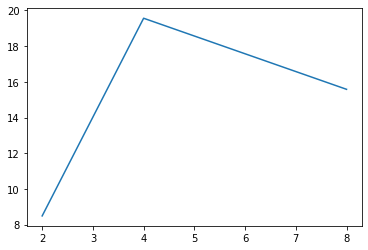

In [37]:
xs, ys = [], []
for n_procs in sorted(per_proc_times.keys()):
    xs.append(n_procs)
    ys.append(per_proc_times[n_procs])
plt.plot(xs, ys)
plt.show()

## Stopping cluster

Finally we can stop the cluster (and stop all nodes) using the `stop_cluster` command. This will also remove the cluster from cluster repository.

Other similar functions are:
* `resume_cluster`: That will resume all paused nodes of a cluster  
* `pause_cluster`: That will pause all nodes of a cluster
* `is_alive`: That will check if all cluster nodes are alive

In [38]:
cluster_manager.stop_cluster(cluster_id)

[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'
[DEPRECATION WARNING]: amazon.aws.ec2 has been deprecated. The ec2 module is 
based upon a deprecated version of the AWS SDKs and is deprecated in favor of 
the ec2_instance module. Please update your tasks. This feature will be removed
 from amazon.aws in version 4.0.0. Deprecation warnings can be disabled by 
setting deprecation_warnings=False in ansible.cfg.

PLAY [localhost] ***************************************************************

TASK [Stopping nodes FredrickParis] ********************************************
[DEPRECATION WARNING]: The 'ec2' module has been deprecated and replaced by the
 'ec2_instance' module'. This feature will be removed from amazon.aws in 
version 4.0.0. Deprecation warnings can be disabled by setting 
deprecation_warnings=False in ansible.cfg.
changed: [localhost]

PLAY RECAP ******************************************************

['3198f74f775d4b2c907e820141543b9f']